# Persona Oluşturma için Kümeleme Analizi

Bu not defteri, `device_featuresv2.csv` dosyasındaki çıkarılmış özellikleri kullanarak kullanıcı personaları oluşturmak için K-Means kümeleme algoritmasını uygular. Bu, orijinal Google Colab not defterinin yerel bir çalışma ortamı için uyarlanmış halidir.

## 1. Ortam Kurulumu ve Kütüphanelerin İçe Aktarılması

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import os

%matplotlib inline
sns.set_style('whitegrid')

## 2. Google Drive Bağlantısı ve Dosya Yolları

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DRIVE_PATH = '/content/drive/MyDrive/' # Kullanıcının kendi Drive yoluna göre güncellenebilir
FEATURES_CSV_NAME = 'device_featuresv2.csv'
# Kullanıcıdan dosyanın tam yolunu Drive içinde belirtmesi istenebilir veya varsayılan bir yol kullanılır.
# Örnek olarak, dosyanın MyDrive ana dizininde olduğunu varsayalım:
features_file_path = os.path.join(BASE_DRIVE_PATH, FEATURES_CSV_NAME)

# Sonuçların ve grafiklerin kaydedileceği klasör (Drive üzerinde)
OUTPUT_RESULTS_PATH = os.path.join(BASE_DRIVE_PATH, 'clustering_results_colab')
os.makedirs(OUTPUT_RESULTS_PATH, exist_ok=True)

print(f"Özellik dosyası yolu (Google Drive): {features_file_path}")
print(f"Sonuçların kaydedileceği dizin (Google Drive): {OUTPUT_RESULTS_PATH}")

Özellik dosyası yolu (Google Drive): /content/drive/MyDrive/device_featuresv2.csv
Sonuçların kaydedileceği dizin (Google Drive): /content/drive/MyDrive/clustering_results_colab


## 3. Veri Yükleme ve İlk İnceleme

In [ ]:
try:
    df_features = pd.read_csv(features_file_path, index_col=0)
    print(f"'{FEATURES_CSV_NAME}' başarıyla yüklendi. Boyut: {df_features.shape}")
    print("\nVeri Tipleri:")
    df_features.info()
    print("\nİlk 5 satır:")
    pd.set_option('display.max_columns', None)
    display(df_features.head())
    pd.reset_option('display.max_columns')
except FileNotFoundError:
    print(f"HATA: Özellik dosyası bulunamadı: {features_file_path}")
    df_features = None
except Exception as e:
    print(f"HATA: Veri yüklenirken bir sorun oluştu: {e}")
    df_features = None

'device_featuresv2.csv' başarıyla yüklendi. Boyut: (186956, 120)

Veri Tipleri:
<class 'pandas.core.frame.DataFrame'>
Index: 186956 entries, 579c691c-ad0d-48c1-a537-595019fb8d8f to 2c5acf90-955c-4f3d-934c-c17628e544c7
Columns: 120 entries, total_pings to ratio_dominant_gece_loc_pings_to_total_gece
dtypes: float64(90), int64(29), object(1)
memory usage: 172.6+ MB

İlk 5 satır:


,total_pings,unique_days_active,activity_span_days,pings_in_airport,ratio_in_airport,pings_in_poi,ratio_in_poi,pings_in_clubs,ratio_in_clubs,pings_in_hotels,ratio_in_hotels,pings_in_luxury_houses,ratio_in_luxury_houses,pings_in_turkey_sites,ratio_in_turkey_sites,pings_in_p_schools,ratio_in_p_schools,num_distinct_polygon_types_visited,num_distinct_airport,num_distinct_poi,num_distinct_clubs,num_distinct_hotels,num_distinct_luxury_houses,num_distinct_turkey_sites,num_distinct_p_schools,pings_gece,ratio_gece_pings,pings_sabah,ratio_sabah_pings,pings_ogle,ratio_ogle_pings,pings_aksam,ratio_aksam_pings,pings_airport_gece,ratio_airport_gece_to_total_in_airport,ratio_airport_gece_to_total_device_pings,pings_airport_sabah,ratio_airport_sabah_to_total_in_airport,ratio_airport_sabah_to_total_device_pings,pings_airport_ogle,ratio_airport_ogle_to_total_in_airport,ratio_airport_ogle_to_total_device_pings,pings_airport_aksam,ratio_airport_aksam_to_total_in_airport,ratio_airport_aksam_to_total_device_pings,pings_poi_gece,ratio_poi_gece_to_total_in_poi,ratio_poi_gece_to_total_device_pings,pings_poi_sabah,ratio_poi_sabah_to_total_in_poi,ratio_poi_sabah_to_total_device_pings,pings_poi_ogle,ratio_poi_ogle_to_total_in_poi,ratio_poi_ogle_to_total_device_pings,pings_poi_aksam,ratio_poi_aksam_to_total_in_poi,ratio_poi_aksam_to_total_device_pings,pings_clubs_gece,ratio_clubs_gece_to_total_in_clubs,ratio_clubs_gece_to_total_device_pings,pings_clubs_sabah,ratio_clubs_sabah_to_total_in_clubs,ratio_clubs_sabah_to_total_device_pings,pings_clubs_ogle,ratio_clubs_ogle_to_total_in_clubs,ratio_clubs_ogle_to_total_device_pings,pings_clubs_aksam,ratio_clubs_aksam_to_total_in_clubs,ratio_clubs_aksam_to_total_device_pings,pings_hotels_gece,ratio_hotels_gece_to_total_in_hotels,ratio_hotels_gece_to_total_device_pings,pings_hotels_sabah,ratio_hotels_sabah_to_total_in_hotels,ratio_hotels_sabah_to_total_device_pings,pings_hotels_ogle,ratio_hotels_ogle_to_total_in_hotels,ratio_hotels_ogle_to_total_device_pings,pings_hotels_aksam,ratio_hotels_aksam_to_total_in_hotels,ratio_hotels_aksam_to_total_device_pings,pings_luxury_houses_gece,ratio_luxury_houses_gece_to_total_in_luxury_houses,ratio_luxury_houses_gece_to_total_device_pings,pings_luxury_houses_sabah,ratio_luxury_houses_sabah_to_total_in_luxury_houses,ratio_luxury_houses_sabah_to_total_device_pings,pings_luxury_houses_ogle,ratio_luxury_houses_ogle_to_total_in_luxury_houses,ratio_luxury_houses_ogle_to_total_device_pings,pings_luxury_houses_aksam,ratio_luxury_houses_aksam_to_total_in_luxury_houses,ratio_luxury_houses_aksam_to_total_device_pings,pings_turkey_sites_gece,ratio_turkey_sites_gece_to_total_in_turkey_sites,ratio_turkey_sites_gece_to_total_device_pings,pings_turkey_sites_sabah,ratio_turkey_sites_sabah_to_total_in_turkey_sites,ratio_turkey_sites_sabah_to_total_device_pings,pings_turkey_sites_ogle,ratio_turkey_sites_ogle_to_total_in_turkey_sites,ratio_turkey_sites_ogle_to_total_device_pings,pings_turkey_sites_aksam,ratio_turkey_sites_aksam_to_total_in_turkey_sites,ratio_turkey_sites_aksam_to_total_device_pings,pings_p_schools_gece,ratio_p_schools_gece_to_total_in_p_schools,ratio_p_schools_gece_to_total_device_pings,pings_p_schools_sabah,ratio_p_schools_sabah_to_total_in_p_schools,ratio_p_schools_sabah_to_total_device_pings,pings_p_schools_ogle,ratio_p_schools_ogle_to_total_in_p_schools,ratio_p_schools_ogle_to_total_device_pings,pings_p_schools_aksam,ratio_p_schools_aksam_to_total_in_p_schools,ratio_p_schools_aksam_to_total_device_pings,dominant_gece_location_type,dominant_gece_location_ping_count,ratio_dominant_gece_loc_pings_to_total_gece
579c691c-ad0d-48c1-a537-595019fb8d8f,91,26,29,0,0.0,1,0.010989,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0,1.0,0,0.0,0,0,0,22,0.241758,12,0.131868,32,0.351648,25,0.274725,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,1.0,0.010989,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,

## 4. Kümeleme için Veri Ön İşleme

K-Means gibi mesafe tabanlı algoritmalar için özelliklerin sayısal olması ve ölçeklendirilmesi önemlidir.

In [ ]:
if df_features is not None:
    # Kümelemede kullanılmayacak kategorik/isim sütunlarını belirle
    # Bu sütunlar daha sonra kümeleri yorumlamak için kullanılabilir
    categorical_cols_for_interpretation = [
        'dominant_gece_location_type', 'dominant_gece_location_name',
        'top_1_loc_name', 'top_1_loc_type',
        'top_2_loc_name', 'top_2_loc_type',
        'top_3_loc_name', 'top_3_loc_type',
        'top_neighborhood_name' # Bu sütun orjinal CSV'de olmayabilir, kontrol edilecek
    ]

    # Sadece df_features içinde var olan sütunları al
    categorical_cols_for_interpretation = [col for col in categorical_cols_for_interpretation if col in df_features.columns]
    print(f"Yorumlama için ayrılan kategorik sütunlar: {categorical_cols_for_interpretation}")

    # Kümeleme için kullanılacak sayısal özellikleri seç
    df_for_clustering = df_features.drop(columns=categorical_cols_for_interpretation, errors='ignore')

    # Seçilen tüm sütunların sayısal olduğundan emin ol, gerekirse dönüştür veya çıkar
    cols_to_drop_non_numeric = []
    for col in df_for_clustering.columns:
        if not pd.api.types.is_numeric_dtype(df_for_clustering[col]):
            print(f"Uyarı: '{col}' sütunu ({df_for_clustering[col].dtype}) sayısal değil. pd.to_numeric ile dönüştürülmeye çalışılıyor...")
            try:
                df_for_clustering[col] = pd.to_numeric(df_for_clustering[col], errors='coerce')
                # Eğer dönüştürme sonrası hala sayısal değilse veya tamamı NaN ise çıkar
                if not pd.api.types.is_numeric_dtype(df_for_clustering[col]) or df_for_clustering[col].isnull().all():
                    print(f"'{col}' dönüştürülemedi veya tamamı NaN oldu, kümelemeden çıkarılıyor.")
                    cols_to_drop_non_numeric.append(col)
                elif df_for_clustering[col].isnull().any():
                     print(f"'{col}' dönüştürme sonrası NaN içeriyor. Daha sonra medyan ile doldurulacak.")
            except Exception as e:
                print(f"'{col}' dönüştürülürken hata: {e}. Kümelemeden çıkarılıyor.")
                cols_to_drop_non_numeric.append(col)

    if cols_to_drop_non_numeric:
        df_for_clustering = df_for_clustering.drop(columns=cols_to_drop_non_numeric)

    print(f"\nKümeleme için seçilen sayısal özellik sayısı: {df_for_clustering.shape[1]}")
    # print("Kümeleme için kullanılacak özellikler:", df_for_clustering.columns.tolist())

    # Eksik değerleri doldurma (medyan ile)
    if df_for_clustering.isnull().sum().sum() > 0:
        print("\nSayısal özelliklerde eksik değerler bulundu. Medyan ile dolduruluyor...")
        for col in df_for_clustering.columns:
            if df_for_clustering[col].isnull().any():
                median_val = df_for_clustering[col].median()
                df_for_clustering[col].fillna(median_val, inplace=True)
                print(f"'{col}' sütunundaki NaN değerler {median_val} ile dolduruldu.")
    else:
        print("\nSayısal özelliklerde eksik değer bulunmuyor.")

    print(f"\nNaN doldurma sonrası özellik sayısı: {df_for_clustering.shape[1]}")
    initial_feature_count_before_selection = df_for_clustering.shape[1]

    # Özellik Seçimi Adımları Eklenecek
    # Bu noktada df_for_clustering üzerinde çalışacağız.
else:
    print("df_features yüklenemediği için ön işleme yapılamadı.")
    df_for_clustering = None # Ensure it's None if not processed


Yorumlama için ayrılan kategorik sütunlar: ['dominant_gece_location_type']

Kümeleme için seçilen sayısal özellik sayısı: 119

Sayısal özelliklerde eksik değerler bulundu. Medyan ile dolduruluyor...
'pings_poi_gece' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_poi_sabah' sütunundaki NaN değerler 1.0 ile dolduruldu.
'pings_poi_ogle' sütunundaki NaN değerler 1.0 ile dolduruldu.
'pings_poi_aksam' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_hotels_gece' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_hotels_sabah' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_hotels_ogle' sütunundaki NaN değerler 1.0 ile dolduruldu.
'pings_hotels_aksam' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_luxury_houses_gece' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_luxury_houses_sabah' sütunundaki NaN değerler 1.0 ile dolduruldu.
'pings_luxury_houses_ogle' sütunundaki NaN değerler 0.0 ile dolduruldu.
'pings_luxury_houses_aksam' sütunundaki NaN değerler 0.0 ile dolduruldu.

<ipython-input-18-aa851534062c>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_for_clustering[col].fillna(median_val, inplace=True)


### 4.1. Düşük Varyanslı Özelliklerin Kaldırılması

In [ ]:
from sklearn.feature_selection import VarianceThreshold

if 'df_for_clustering' in locals() and df_for_clustering is not None and not df_for_clustering.empty:
    print(f"Düşük varyans filtresi öncesi özellik sayısı: {df_for_clustering.shape[1]}")
    # Eşik değeri 0.0 olarak ayarlandı (sadece varyansı sıfır olanları kaldırır).
    # Farklı bir eşik denenebilir, örn: 0.01 veya 0.1, ancak bu özelliklerin ölçeğine bağlıdır.
    # Ölçeklendirme sonrası uygulamak daha standart olabilir ama burada ham verilere uyguluyoruz.
    variance_selector = VarianceThreshold(threshold=0.0)
    try:
        df_for_clustering_variancetrimmed = variance_selector.fit_transform(df_for_clustering)
        # Getfeature_names_out, VarianceThreshold'dan sonra sütun isimlerini korumak için önemlidir.
        selected_cols_variance = variance_selector.get_feature_names_out(input_features=df_for_clustering.columns)
        df_for_clustering = pd.DataFrame(df_for_clustering_variancetrimmed, columns=selected_cols_variance, index=df_for_clustering.index)
        print(f"Düşük varyans filtresi sonrası özellik sayısı: {df_for_clustering.shape[1]}")
        removed_count = initial_feature_count_before_selection - len(selected_cols_variance)
        if removed_count > 0:
             print(f"{removed_count} adet düşük varyanslı özellik kaldırıldı.")
        else:
             print("Düşük varyans filtresi ile özellik kaldırılmadı.")
    except ValueError as e:
        print(f"Varyans eşikleme sırasında hata (muhtemelen hiç özellik kalmadı veya hepsi NaN): {e}")
        print("Bu adım atlanıyor.")
else:
    print("df_for_clustering bulunamadı veya boş, düşük varyans filtresi atlandı.")

Düşük varyans filtresi öncesi özellik sayısı: 119
Düşük varyans filtresi sonrası özellik sayısı: 86
33 adet düşük varyanslı özellik kaldırıldı.


### 4.2. Yüksek Korelasyonlu Özelliklerin Kaldırılması

In [ ]:
if 'df_for_clustering' in locals() and df_for_clustering is not None and not df_for_clustering.empty:
    print(f"\nYüksek korelasyon filtresi öncesi özellik sayısı: {df_for_clustering.shape[1]}")
    corr_matrix = df_for_clustering.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Yüksek korelasyon eşiği (örneğin 0.95)
    correlation_threshold = 0.95
    cols_to_drop_corr = set()
    for column in upper_triangle.columns:
        if column not in cols_to_drop_corr: # Eğer zaten silinecekler listesinde değilse
            highly_correlated_with_column = upper_triangle[upper_triangle[column] > correlation_threshold].index
            for correlated_col in highly_correlated_with_column:
                if correlated_col not in cols_to_drop_corr: # Eğer bu da zaten silinecekler listesinde değilse
                    cols_to_drop_corr.add(correlated_col) # İkinci olanı (veya listede sonra geleni) sil
                    print(f"'{correlated_col}' sütunu '{column}' ile yüksek korelasyonlu ({corr_matrix.loc[column, correlated_col]:.2f}), '{correlated_col}' kaldırılacak.")

    if cols_to_drop_corr:
        df_for_clustering = df_for_clustering.drop(columns=list(cols_to_drop_corr))
        print(f"\nYüksek korelasyon filtresi sonrası özellik sayısı: {df_for_clustering.shape[1]}")
        print(f"{len(cols_to_drop_corr)} adet yüksek korelasyonlu özellik kaldırıldı: {list(cols_to_drop_corr)}")
    else:
        print("\nYüksek korelasyon filtresi ile özellik kaldırılmadı.")
else:
    print("df_for_clustering bulunamadı veya boş, yüksek korelasyon filtresi atlandı.")


Yüksek korelasyon filtresi öncesi özellik sayısı: 86
'pings_in_turkey_sites' sütunu 'pings_turkey_sites_gece' ile yüksek korelasyonlu (0.95), 'pings_in_turkey_sites' kaldırılacak.
'pings_poi_gece' sütunu 'dominant_gece_location_ping_count' ile yüksek korelasyonlu (0.97), 'pings_poi_gece' kaldırılacak.

Yüksek korelasyon filtresi sonrası özellik sayısı: 84
2 adet yüksek korelasyonlu özellik kaldırıldı: ['pings_in_turkey_sites', 'pings_poi_gece']


### 4.3. Özellik Ölçeklendirme

In [ ]:
if 'df_for_clustering' in locals() and df_for_clustering is not None and not df_for_clustering.empty:
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_for_clustering)
    print("\nÖzellikler başarıyla ölçeklendirildi.")
    print(f"Ölçeklendirilmiş özellik matrisi boyutu: {scaled_features.shape}")
else:
    print("df_for_clustering bulunamadı, boş veya özellik seçimi sonrası hiç özellik kalmadı. Ölçeklendirme atlandı.")
    scaled_features = None # Ensure it's None if not processed


Özellikler başarıyla ölçeklendirildi.
Ölçeklendirilmiş özellik matrisi boyutu: (186956, 84)


## 5. Optimal Küme Sayısını Belirleme (k)

Elbow metodu ve Silhouette analizi gibi teknikler optimal küme sayısını belirlemede yardımcı olabilir.


Truncated SVD ile boyut indirgeme uygulanıyor...
Truncated SVD ile 50 bileşene indirgendi.
Toplam açıklanan varyans oranı: 0.9542


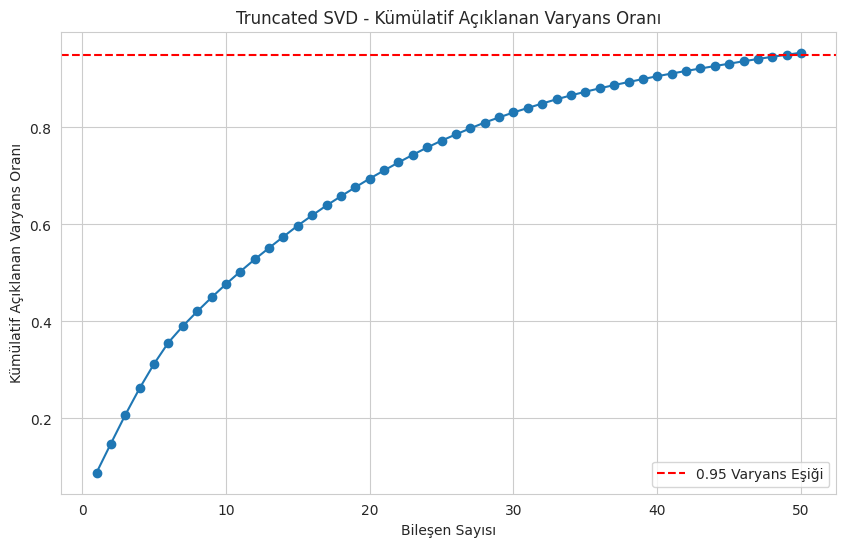

SVD kümülatif varyans grafiği kaydedildi: /content/drive/MyDrive/clustering_results_colab/svd_variance_plot.png
İndirgenmiş özellik matrisi boyutu: (186956, 50)

Optimal k için Elbow ve Silhouette skorları hesaplanıyor...
k=2 için Inertia: 14146373.82, Silhouette Skoru: 0.4302
k=3 için Inertia: 13742221.31, Silhouette Skoru: 0.4172
k=4 için Inertia: 13437860.92, Silhouette Skoru: 0.2957
k=5 için Inertia: 13276867.87, Silhouette Skoru: 0.1825
k=6 için Inertia: 13159000.48, Silhouette Skoru: 0.1330
k=7 için Inertia: 12518818.52, Silhouette Skoru: 0.3186
k=8 için Inertia: 12829674.31, Silhouette Skoru: 0.2113
k=9 için Inertia: 12497229.53, Silhouette Skoru: 0.2575
k=10 için Inertia: 12594935.00, Silhouette Skoru: 0.1819


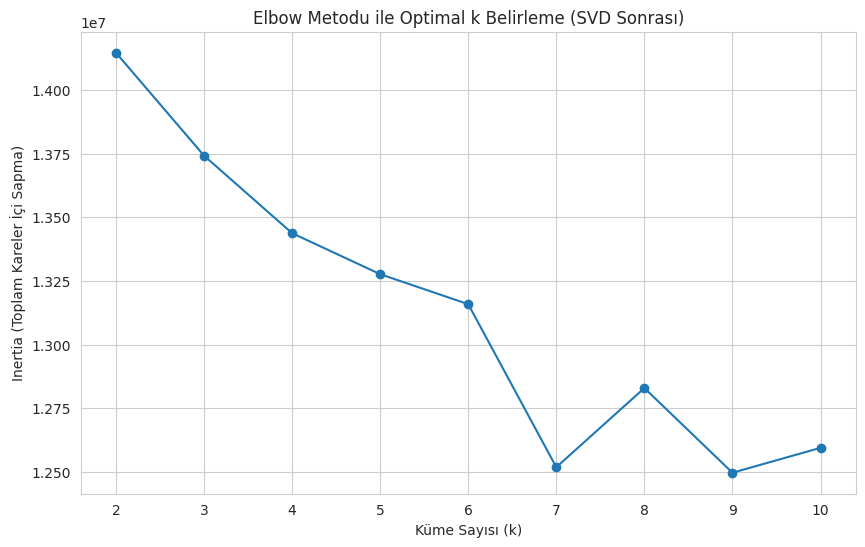

Elbow metodu grafiği kaydedildi: /content/drive/MyDrive/clustering_results_colab/elbow_plot_svd.png


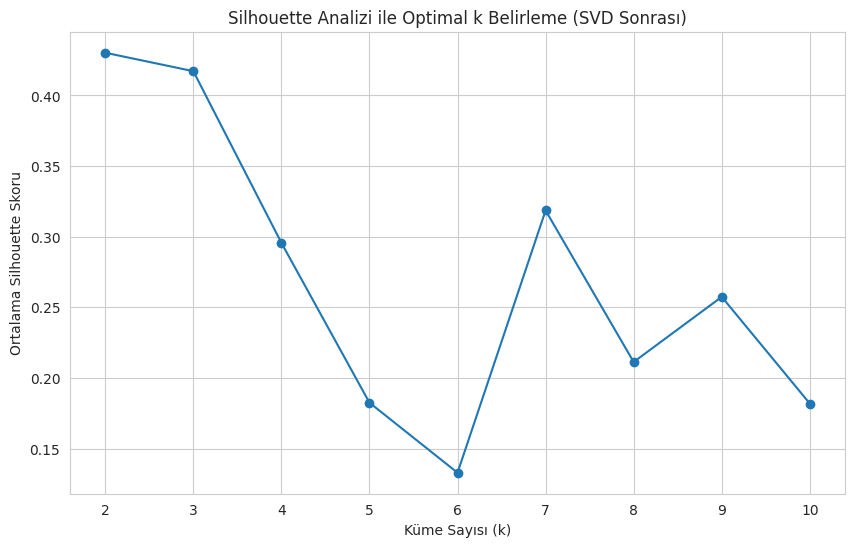

Silhouette analizi grafiği kaydedildi: /content/drive/MyDrive/clustering_results_colab/silhouette_plot_svd.png

Elbow grafiğinde 'dirsek' noktası ve Silhouette grafiğinde en yüksek skor, potansiyel optimal k değerlerini gösterir.
SVD sonrası indirgenmiş özelliklerle kümeleme yapıldı. İşletme/alan bilginizle birlikte bu metrikleri kullanarak bir sonraki hücrede OPTIMAL_K değerini belirleyin.


In [ ]:
# Cell under Section 5: Optimal K Belirleme
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import os

if 'scaled_features' in locals() and scaled_features is not None:
    print("\nTruncated SVD ile boyut indirgeme uygulanıyor...")

    # Determine number of components (e.g., retain 95% of variance or set a fixed number)
    n_components_target = min(50, scaled_features.shape[1])  # Start with a reasonable number or max available
    svd = TruncatedSVD(n_components=n_components_target, random_state=42)
    reduced_features = svd.fit_transform(scaled_features)

    # Calculate explained variance ratio
    explained_variance_ratio = svd.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    print(f"Truncated SVD ile {n_components_target} bileşene indirgendi.")
    print(f"Toplam açıklanan varyans oranı: {cumulative_variance_ratio[-1]:.4f}")

    # Plot cumulative explained variance to guide component selection
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
    plt.title('Truncated SVD - Kümülatif Açıklanan Varyans Oranı')
    plt.xlabel('Bileşen Sayısı')
    plt.ylabel('Kümülatif Açıklanan Varyans Oranı')
    plt.axhline(y=0.95, color='r', linestyle='--', label='0.95 Varyans Eşiği')
    plt.legend()
    plt.grid(True)
    svd_variance_plot_path = os.path.join(OUTPUT_RESULTS_PATH, 'svd_variance_plot.png')
    plt.savefig(svd_variance_plot_path)
    plt.show()
    print(f"SVD kümülatif varyans grafiği kaydedildi: {svd_variance_plot_path}")

    # Optional: Automatically select number of components to retain 95% variance
    n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1 if np.any(cumulative_variance_ratio >= 0.95) else n_components_target
    if n_components_95 < n_components_target:
        print(f"95% varyansı açıklamak için {n_components_95} bileşen yeterli. Yeniden indirgeme yapılıyor...")
        svd = TruncatedSVD(n_components=n_components_95, random_state=42)
        reduced_features = svd.fit_transform(scaled_features)
        print(f"Truncated SVD ile {n_components_95} bileşene indirgendi.")
        print(f"Yeni toplam açıklanan varyans oranı: {np.sum(svd.explained_variance_ratio_):.4f}")

    print(f"İndirgenmiş özellik matrisi boyutu: {reduced_features.shape}")

    # Clustering with MiniBatchKMeans using reduced features
    inertia = []
    silhouette_scores = []
    k_range = range(2, 11)  # 2'den 10'a kadar küme sayısı

    print("\nOptimal k için Elbow ve Silhouette skorları hesaplanıyor...")
    for k_val in k_range:
        kmeans = MiniBatchKMeans(n_clusters=k_val, random_state=42, batch_size=10000, n_init='auto')
        cluster_labels = kmeans.fit_predict(reduced_features)  # Use reduced_features instead of scaled_features
        inertia.append(kmeans.inertia_)

        if len(np.unique(cluster_labels)) > 1:
            sample_size = min(50000, reduced_features.shape[0])
            sampled_indices = np.random.choice(reduced_features.shape[0], sample_size, replace=False)
            sampled_features = reduced_features[sampled_indices]
            sampled_labels = cluster_labels[sampled_indices]
            silhouette_avg = silhouette_score(sampled_features, sampled_labels)
            silhouette_scores.append(silhouette_avg)
            print(f"k={k_val} için Inertia: {kmeans.inertia_:.2f}, Silhouette Skoru: {silhouette_avg:.4f}")
        else:
            silhouette_scores.append(np.nan)
            print(f"k={k_val} için Inertia: {kmeans.inertia_:.2f}, Silhouette Skoru: Hesaplanamadı (tek küme bulundu)")

    # Elbow Plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='-')
    plt.title('Elbow Metodu ile Optimal k Belirleme (SVD Sonrası)')
    plt.xlabel('Küme Sayısı (k)')
    plt.ylabel('Inertia (Toplam Kareler İçi Sapma)')
    plt.xticks(k_range)
    plt.grid(True)
    elbow_plot_path = os.path.join(OUTPUT_RESULTS_PATH, 'elbow_plot_svd.png')
    plt.savefig(elbow_plot_path)
    plt.show()
    print(f"Elbow metodu grafiği kaydedildi: {elbow_plot_path}")

    # Silhouette Plot
    valid_k_for_silhouette = [k_range[i] for i, score in enumerate(silhouette_scores) if not np.isnan(score)]
    valid_silhouette_scores = [score for score in silhouette_scores if not np.isnan(score)]
    if valid_silhouette_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(valid_k_for_silhouette, valid_silhouette_scores, marker='o', linestyle='-')
        plt.title('Silhouette Analizi ile Optimal k Belirleme (SVD Sonrası)')
        plt.xlabel('Küme Sayısı (k)')
        plt.ylabel('Ortalama Silhouette Skoru')
        plt.xticks(valid_k_for_silhouette)
        plt.grid(True)
        silhouette_plot_path = os.path.join(OUTPUT_RESULTS_PATH, 'silhouette_plot_svd.png')
        plt.savefig(silhouette_plot_path)
        plt.show()
        print(f"Silhouette analizi grafiği kaydedildi: {silhouette_plot_path}")
    else:
        print("Silhouette analizi için geçerli skor bulunamadı, grafik oluşturulmadı.")

    print("\nElbow grafiğinde 'dirsek' noktası ve Silhouette grafiğinde en yüksek skor, potansiyel optimal k değerlerini gösterir.")
    print("SVD sonrası indirgenmiş özelliklerle kümeleme yapıldı. İşletme/alan bilginizle birlikte bu metrikleri kullanarak bir sonraki hücrede OPTIMAL_K değerini belirleyin.")
else:
    print("Ölçeklendirilmiş özellikler bulunamadı, SVD ve k belirleme adımı atlandı.")

## 6. K-Means Kümeleme Uygulaması

Yukarıdaki analizlere dayanarak `OPTIMAL_K` değerini belirleyin ve aşağıdaki hücrede güncelleyin.

In [ ]:
# Cell under Section 6: K-Means Kümeleme Uygulaması
# Önceki adımdaki grafiklere ve skorlara bakarak OPTIMAL_K değerini belirleyin.
# Örnek olarak k=4 seçilmiştir. Bu değeri kendi analizinize göre güncelleyin.
OPTIMAL_K = 3

if 'reduced_features' in locals() and reduced_features is not None:
    print(f"Seçilen küme sayısı (OPTIMAL_K): {OPTIMAL_K}")

    kmeans_final = MiniBatchKMeans(n_clusters=OPTIMAL_K, random_state=42, batch_size=10000, n_init='auto')
    # Orijinal df_features'a cluster sütununu eklemeden önce index'lerin eşleştiğinden emin olalım.
    df_features['cluster'] = kmeans_final.fit_predict(reduced_features)  # Use reduced_features

    print("\nKümeleme tamamlandı. 'cluster' sütunu df_features'a eklendi.")
    display(df_features[['cluster']].head())
    print("\nHer kümedeki üye sayısı:")
    display(df_features['cluster'].value_counts().sort_index())
else:
    print("İndirgenmiş özellikler bulunamadı, kümeleme adımı atlandı.")

Seçilen küme sayısı (OPTIMAL_K): 3

Kümeleme tamamlandı. 'cluster' sütunu df_features'a eklendi.


,cluster
579c691c-ad0d-48c1-a537-595019fb8d8f,1
aac74dea-1d11-62ce-a42a-4719c7913979,1
c3120561-95b7-4010-9b01-ea7ac2128343,1
8fd8ac7e-1364-4528-89b5-a1a1f2a55b23,0
be969d25-6296-68a0-a8c2-54d39012ae5e,1



Her kümedeki üye sayısı:


,count
cluster,
0,14566
1,24631
2,147759


## 7. Kümeleri (Personaları) Analiz Etme ve Yorumlama

Oluşan kümelerin özelliklerini inceleyerek personaları tanımlayın.

In [ ]:
if 'df_features' in locals() and 'cluster' in df_features.columns:
    # Sayısal özelliklerin küme bazında ortalamalarını inceleme (orijinal ölçekte değil, ölçeklenmemiş df_for_clustering üzerinden)
    # df_for_clustering, kümeleme için kullanılan son haldeki sayısal özellikleri içerir.
    df_analysis_numerical = df_for_clustering.copy()
    df_analysis_numerical['cluster'] = df_features.loc[df_analysis_numerical.index, 'cluster'] # Eşleşen index'ler üzerinden cluster ata

    cluster_profiles_mean = df_analysis_numerical.groupby('cluster').mean()
    # cluster_profiles_median = df_analysis_numerical.groupby('cluster').median() # İsterseniz medyanı da inceleyebilirsiniz

    print("\n--- Küme Profilleri (Sayısal Özelliklerin Ortalama Değerleri) ---")
    pd.set_option('display.max_rows', 200) # Daha fazla satır göstermek için
    pd.set_option('display.max_columns', None)
    display(cluster_profiles_mean.T) # Transpoze ederek daha okunaklı hale getirelim
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

    # Sayısal profilin CSV olarak kaydedilmesi
    cluster_profiles_path = os.path.join(OUTPUT_RESULTS_PATH, 'cluster_profiles_numerical_mean.csv')
    try:
        cluster_profiles_mean.T.to_csv(cluster_profiles_path)
        print(f"\nSayısal küme profilleri (ortalama) başarıyla '{cluster_profiles_path}' dosyasına kaydedildi.")
    except Exception as e:
        print(f"HATA: Sayısal küme profilleri kaydedilirken bir sorun oluştu: {e}")

    # Kategorik özelliklerin küme bazında dağılımlarını inceleme
    print("\n--- Küme Profilleri (Yorumlama İçin Ayrılan Kategorik Özellikler) ---")
    for cat_col in categorical_cols_for_interpretation:
        if cat_col in df_features.columns:
            print(f"\n'{cat_col}' sütununun kümelere göre dağılımı (En sık ilk 3):")
            for cluster_id in sorted(df_features['cluster'].unique()):
                print(f"  Küme {cluster_id}:")
                value_counts_series = df_features[df_features['cluster'] == cluster_id][cat_col].value_counts(dropna=False)
                if not value_counts_series.empty:
                    display(value_counts_series.head(3))
                else:
                    print("    (Veri yok veya tamamı NaN)")
        else:
            print(f"'{cat_col}' sütunu df_features içinde bulunamadı, yorumlama için atlandı.")

    # Persona İsimlendirme Önerisi:
    # Yukarıdaki analizlere dayanarak her bir kümeye anlamlı bir persona ismi verin.
    # Örnek:
    # persona_names = {
    #     0: "Gece Kuşları",
    #     1: "Gündüz Gezginleri",
    #     2: "Hafta Sonu Kaşifleri",
    #     3: "Evcimenler"
    # }
    # df_features['persona_name'] = df_features['cluster'].map(persona_names)
    # print("\nPersona isimleri eklendi (örnek):")
    # display(df_features[['cluster', 'persona_name']].head())

else:
    print("Kümeleme yapılmadığı veya df_features yüklenemediği için analiz adımı atlandı.")


--- Küme Profilleri (Sayısal Özelliklerin Ortalama Değerleri) ---


cluster,0,1,2,3
total_pings,15.143309,1.538475e+02,1.047119e+01,3.069499e+01
unique_days_active,4.187082,2.398072e+01,3.276004e+00,8.066849e+00
activity_span_days,5.477010,2.600563e+01,4.253349e+00,1.174736e+01
pings_in_poi,4.816376,8.244432e+00,1.481829e-01,2.851512e+00
ratio_in_poi,0.534323,6.282369e-02,2.535083e-02,2.395936e-01
pings_in_hotels,0.000000,5.986590e-04,0.000000e+00,1.143015e-03
ratio_in_hotels,0.000000,1.763688e-06,0.000000e+00,1.434263e-04
pings_in_luxury_houses,0.007872,2.292864e-02,1.878111e-04,3.532957e-03
ratio_in_luxury_houses,0.000583,1.986206e-04,1.645659e-05,2.476496e-04
ratio_in_turkey_sites,0.014758,5.555421e-04,6.109100e-05,3.657829e-04



Sayısal küme profilleri (ortalama) başarıyla '/content/drive/MyDrive/clustering_results_colab/cluster_profiles_numerical_mean.csv' dosyasına kaydedildi.

--- Küme Profilleri (Yorumlama İçin Ayrılan Kategorik Özellikler) ---

'dominant_gece_location_type' sütununun kümelere göre dağılımı (En sık ilk 3):
  Küme 0:


,count
dominant_gece_location_type,
poi,8609
NaN,4699
turkey_sites,249


  Küme 1:


,count
dominant_gece_location_type,
NaN,11168
poi,5488
turkey_sites,25


  Küme 2:


,count
dominant_gece_location_type,
NaN,127651
poi,136
luxury_houses,1


  Küme 3:


,count
dominant_gece_location_type,
NaN,26160
poi,2693
luxury_houses,8


## 8. Sonuçları Kaydetme (İsteğe Bağlı)

Eğer küme etiketlerini veya persona isimlerini orijinal özelliklerle birlikte kaydetmek isterseniz:

In [ ]:
if 'df_features' in locals() and 'cluster' in df_features.columns:
    output_clustered_file_path = os.path.join(OUTPUT_RESULTS_PATH, 'device_features_clustered_local.csv')
    try:
        df_features.to_csv(output_clustered_file_path, index=True) # device_aid index olarak kaydedilecek
        print(f"\nKümelenmiş özellikler başarıyla '{output_clustered_file_path}' dosyasına kaydedildi.")
    except Exception as e:
        print(f"HATA: Kümelenmiş özellikler kaydedilirken bir sorun oluştu: {e}")
else:
    print("Kaydedilecek kümelenmiş veri bulunmuyor.")


Kümelenmiş özellikler başarıyla '/content/drive/MyDrive/clustering_results_colab/device_features_clustered_local.csv' dosyasına kaydedildi.
